In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('data/final_df.csv')

# Feature Engineering

In [3]:
# Drop Nulls in Temperature
#df = df.dropna(subset=['weather_temperature'])

#df['stadium_wind'] = np.where((df['stadium_capacity'] > 60000) & (df['weather_wind_mph'] > 14), 1, 0)


# Drop Uneeded Rows
df = df.drop(columns=['unix', 'time', 'stadium_name','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','ELEVATION','team_away','team_home','team_favorite_id',
                      'LATITUDE','LONGITUDE','zipcode','zipcode_away','home_OSRS','home_MoV','home_PD','away_OSRS',
                      'away_MoV','away_PD','away_DSRS','away_SRS'])
 
df.drop(columns=['score_home','score_away', 'stadium_location','total'],inplace=True)
df.drop('schedule_date', axis=1,inplace=True)

# Transform Over/Under Results to Binary 0 = Under, 1 = Over
df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)
# Transform Stadium Surface to Binary 0 = Turf, 1 = Grass 
df['stadium_surface'] = np.where(df['stadium_surface'] == 'Grass',1,0)

# True/False to Binary 0 = False, 1 = True
df['schedule_playoff'] = list(map(int, df['schedule_playoff']))
df['stadium_neutral'] = list(map(int, df['stadium_neutral']))


#df = df.dropna

# Get Dummies for Categorical Variables
df = pd.get_dummies(df, columns = ['icon'], drop_first= True)
df = pd.get_dummies(df, columns = ['summary'], drop_first= True)
df = pd.get_dummies(df, columns = ['stadium_type'], drop_first= True)
#df = pd.get_dummies(df, columns = ['weather_detail'], drop_first= True)
#df = pd.get_dummies(df, columns = ['stadium_name'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_home'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_away'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_favorite_id'], drop_first= True)

# Transform Uint8 values to Integers
uint8_columns = list(df.select_dtypes('uint8').columns)
for colname in df.columns:
    if colname in uint8_columns:
        df[colname] = df[colname].astype(int)

df = df.dropna()

In [4]:
df.columns[df.isnull().any()]
#print(df.shape)
#df.columns

Index([], dtype='object')

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df.dtypes

schedule_season                                  int64
schedule_week                                    int64
schedule_playoff                                 int64
spread_favorite                                float64
over_under_line                                float64
stadium_neutral                                  int64
over_under_result                                int64
stadium_open                                     int64
stadium_capacity                                 int64
stadium_surface                                  int64
weekday                                          int64
dist_diff                                      float64
home_W-L%                                      float64
home_SoS                                       float64
home_SRS                                       float64
home_DSRS                                      float64
home_PF_per_game                               float64
home_PA_per_game                               float64
away_W-L% 

# Feature Selection

In [6]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('over_under_result', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['over_under_result'] # y is the column we're trying to predict

In [7]:
np.abs(df.corr()['over_under_result']).sort_values(ascending=False)

over_under_result                              1.000000
over_under_line                                0.027211
precipIntensity                                0.025543
windSpeed                                      0.025436
summary_Heavy Rain and Humid                   0.025092
away_SoS                                       0.024355
windBearing                                    0.024158
dist_diff                                      0.023113
away_W-L%                                      0.020972
home_SoS                                       0.020884
summary_Dangerously Windy and Mostly Cloudy    0.020484
home_PF_per_game                               0.019219
summary_Overcast                               0.017669
summary_Windy and Partly Cloudy                0.017236
summary_Rain and Humid                         0.017053
diff_PA_per_game                               0.016215
summary_Dangerously Windy and Overcast         0.016135
summary_Windy                                  0

In [8]:
corrs_dict={}
for col in X.columns:
    corr=y.corr(X[col])
    corrs_dict[corr]=col
    
sorted(corrs_dict.items(),reverse=True)

[(0.024354712902293206, 'away_SoS'),
 (0.02415829448036749, 'windBearing'),
 (0.023113033766051255, 'dist_diff'),
 (0.020972375484302037, 'away_W-L%'),
 (0.02048390534185938, 'summary_Dangerously Windy and Mostly Cloudy'),
 (0.019219367645425627, 'home_PF_per_game'),
 (0.01766882892533071, 'summary_Overcast'),
 (0.01621484600369565, 'diff_PA_per_game'),
 (0.0154502497581088, 'icon_cloudy'),
 (0.015103376649069281, 'cloudCover'),
 (0.014672233590768096, 'home_SRS'),
 (0.014482832264548847, 'summary_Dangerously Windy and Partly Cloudy'),
 (0.014452182005209794, 'home_W-L%'),
 (0.01420668800358111, 'summary_Flurries'),
 (0.011834632136986425, 'diff_PF_per_game'),
 (0.011691474751157765, 'summary_Drizzle'),
 (0.011601321879008255, 'diff_OSRS'),
 (0.011533790672971042, 'summary_Mostly Cloudy'),
 (0.010727384869833396, 'diff_MoV'),
 (0.010271813918566393, 'schedule_week'),
 (0.01024038714176305, 'summary_Possible Drizzle and Windy'),
 (0.01024038714176302, 'summary_Windy and Humid'),
 (0.010

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X)

Vif.sort_values('VIF',ascending=False)[:5]

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Features
48,inf,icon_partly-cloudy-day
76,inf,summary_Possible Drizzle and Humid
54,inf,summary_Dangerously Windy and Overcast
53,inf,summary_Dangerously Windy and Mostly Cloudy
52,inf,summary_Dangerously Windy


# Baseline Models

### Train Test Split

In [10]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=5)

### Scale Data

In [11]:
# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X.columns)

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)

base_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
base_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Train F1 score:  0.543
Test F1 score:  0.515


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

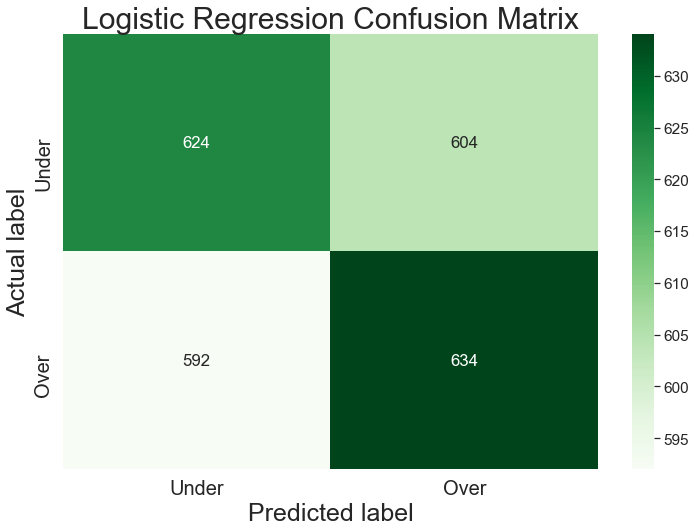

In [13]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, base_logred_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Logistic Regression Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
plt.savefig('log_confusion.png')

### Decision Tree

In [14]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

dtc = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 6, min_samples_leaf = 6, min_samples_split = 6)
dtc.fit(X_train, y_train)

dtc_train_pred = dtc.predict(X_train)
dtc_test_pred = dtc.predict(X_test)

dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', dtc_f1_train)
print('Test F1 score: ', dtc_f1_test)


Train F1 score:  0.608
Test F1 score:  0.554


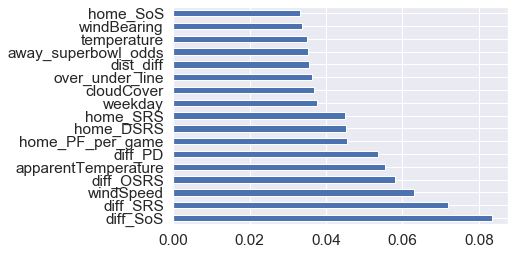

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

feat_importances = pd.Series(dtc.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Over','Under'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

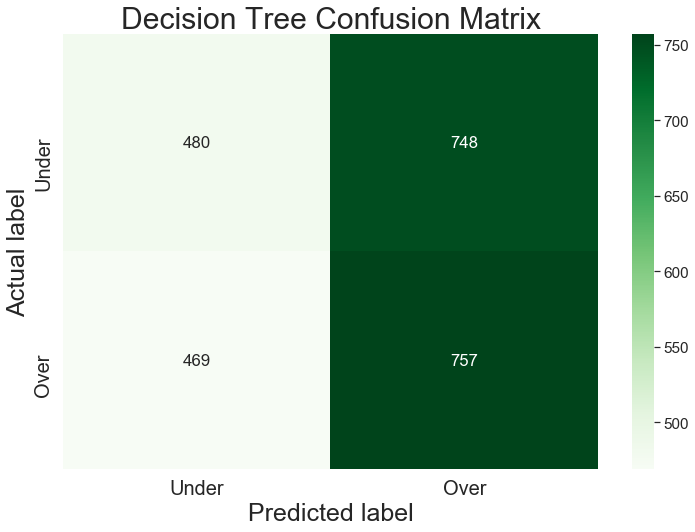

In [16]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, dtc_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Decision Tree Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

In [18]:
rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Train F1 score:  0.533
Test F1 score:  0.402


Text(0.5, 44.5, 'Predicted label')

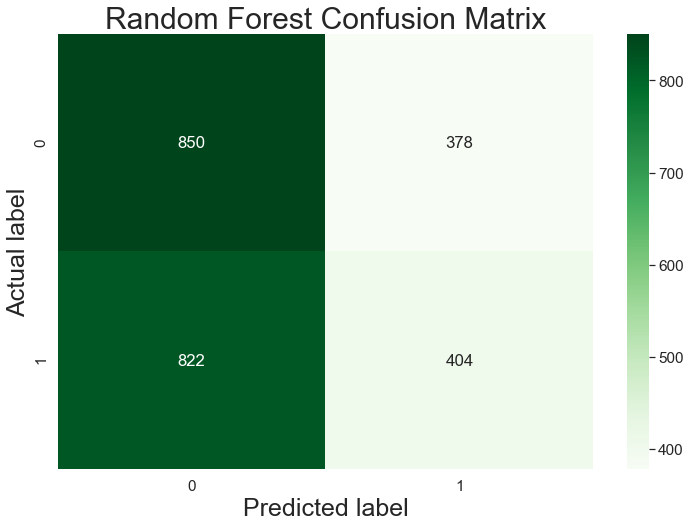

In [19]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, rfc_predicted, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Random Forest Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
#cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
#cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

### SVM Model

In [20]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)
svm_pred_train = svm.predict(X_train)

#Score
svm_f1_train = round(f1_score(y_train, svm_pred_train), 3)
svm_f1_test = round(f1_score(y_test, svm_pred), 3)

print('Train F1 score: ', svm_f1_train)
print('Test F1 score: ', svm_f1_test)

Train F1 score:  0.629
Test F1 score:  0.483


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

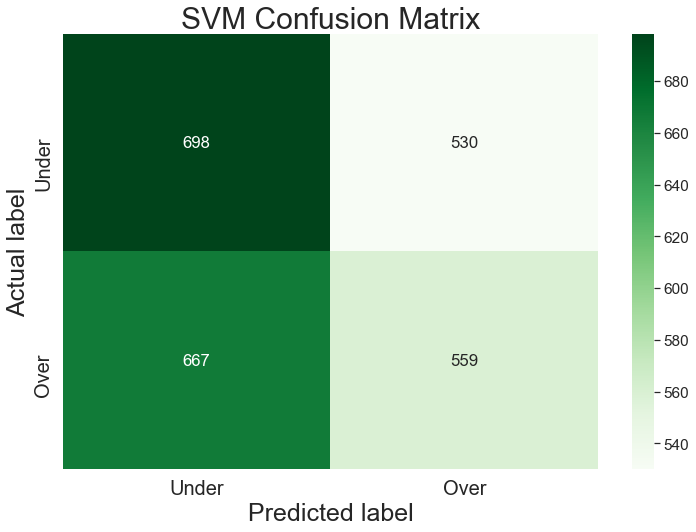

In [21]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, svm_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('SVM Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

# KNN

Maximum accuracy:- 0.5485943775100403 at K = 0


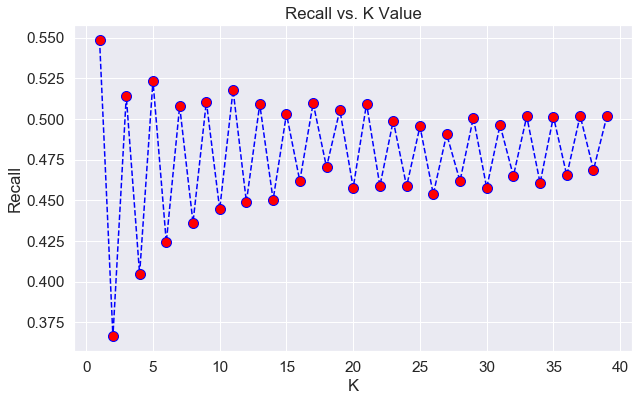

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Will take some time
acc = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    acc.append(metrics.f1_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Recall vs. K Value')
plt.xlabel('K')
plt.ylabel('Recall')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [23]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)

KNN_train_preds = knn.predict(X_train)
KNN_preds = knn.predict(X_test)

In [24]:
KNN_recall = metrics.recall_score(y_test, KNN_preds)
KNN_train_f1_score = f1_score(y_train, KNN_train_preds)
KNN_f1_score = f1_score(y_test, KNN_preds)


print('Recall Score: ', KNN_recall)
print('Train F1 score: ', KNN_train_f1_score)
print('Test F1 score: ', KNN_f1_score)

Recall Score:  0.5570962479608483
Train F1 score:  1.0
Test F1 score:  0.5485943775100403


### Final Scores 

In [25]:
print('Baseline Logistic Regression:')
print('      Train F1 score: ', base_logred_train_f1_score)
print('      Test F1 score: ', base_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Train F1 score: ', dtc_f1_train)
print('      Test F1 score: ', dtc_f1_test)
print('')
print('Random Forest:')
print('      Train F1 score: ', rfc_f1_train)
print('      Test F1 score: ', rfc_f1_test)
print('')
print('Support Vector Machine:')
print('      Train F1 score: ', svm_f1_train)
print('      Test F1 score: ', svm_f1_test)

Baseline Logistic Regression:
      Train F1 score:  0.543
      Test F1 score:  0.515

Decision Tree:
      Train F1 score:  0.608
      Test F1 score:  0.554

Random Forest:
      Train F1 score:  0.533
      Test F1 score:  0.402

Support Vector Machine:
      Train F1 score:  0.629
      Test F1 score:  0.483


# Model Tuning w/ Polynomial Dataset

In [26]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X)
poly2_columns = poly_2.get_feature_names(X.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(9815, 4752)


,schedule_season,schedule_week,schedule_playoff,spread_favorite,over_under_line,stadium_neutral,stadium_open,stadium_capacity,stadium_surface,weekday,dist_diff,home_W-L%,home_SoS,home_SRS,home_DSRS,home_PF_per_game,home_PA_per_game,away_W-L%,away_SoS,away_PF_per_game,away_PA_per_game,home_superbowl_odds,away_superbowl_odds,diff_W-L%,diff_PD,diff_MoV,diff_SoS,diff_SRS,diff_OSRS,diff_PF_per_game,diff_PA_per_game,diff_superbowl_odds,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility,icon_clear-day,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind,summary_Dangerously Windy,summary_Dangerously Windy and Mostly Cloudy,summary_Dangerously Windy and Overcast,summary_Dangerously Windy and Partly Cloudy,summary_Drizzle,summary_Drizzle and Humid,summary_Flurries,summary_Flurries and Windy,summary_Foggy,summary_Heavy Rain,summary_Heavy Rain and Humid,summary_Heavy Snow,summary_Humid,summary_Humid and Mostly Cloudy,summary_Humid and Overcast,summary_Humid and Partly Cloudy,summary_Light Rain,summary_Light Rain and Humid,summary_Light Snow,summary_Mostly Cloudy,summary_None,summary_Overcast,summary_Partly Cloudy,summary_Possible Drizzle,summary_Possible Drizzle and Humid,summary_Possible Drizzle and Windy,summary_Possible Flurries,summary_Possible Light Rain,summary_Possible Light Rain and Humid,summary_Possible Light Rain and Windy,summary_Possible Light Snow,summary_Rain,summary_Rain and Humid,summary_Rain and Windy,summary_Snow,summary_Snow and Windy,summary_Windy,summary_Windy and Foggy,summary_Windy and Humid,summary_Windy and Mostly Cloudy,summary_Windy and Overcast,summary_Windy and Partly Cloudy,stadium_type_outdoor,stadium_type_retractable,schedule_season^2,schedule_season schedule_week,schedule_season schedule_playoff,schedule_season spread_favorite,schedule_season over_under_line,schedule_season stadium_neutral,schedule_season stadium_open,schedule_season stadium_capacity,schedule_season stadium_surface,schedule_season weekday,schedule_season dist_diff,schedule_season home_W-L%,schedule_season home_SoS,schedule_season home_SRS,schedule_season home_DSRS,schedule_season home_PF_per_game,schedule_season home_PA_per_game,schedule_season away_W-L%,schedule_season away_SoS,schedule_season away_PF_per_game,schedule_season away_PA_per_game,schedule_season home_superbowl_odds,schedule_season away_superbowl_odds,schedule_season diff_W-L%,schedule_season diff_PD,schedule_season diff_MoV,schedule_season diff_SoS,schedule_season diff_SRS,schedule_season diff_OSRS,schedule_season diff_PF_per_game,schedule_season diff_PA_per_game,schedule_season diff_superbowl_odds,schedule_season precipIntensity,schedule_season precipProbability,schedule_season precipType,schedule_season temperature,schedule_season apparentTemperature,schedule_season dewPoint,schedule_season humidity,schedule_season pressure,schedule_season windSpeed,schedule_season windBearing,schedule_season cloudCover,schedule_season uvIndex,schedule_season visibility,schedule_season icon_clear-day,schedule_season icon_cloudy,schedule_season icon_fog,schedule_season icon_partly-cloudy-day,schedule_season icon_rain,schedule_season icon_snow,schedule_season icon_wind,schedule_season summary_Dangerously Windy,schedule_season summary_Dangerously Windy and Mostly Cloudy,schedule_season summary_Dangerously Windy and Overcast,schedule_season summary_Dangerously Windy and Partly Cloudy,schedule_season summary_Drizzle,schedule_season summary_Drizzle and Humid,schedule_season summary_Flurries,schedule_season summary_Flurries and Windy,schedule_season summary_Foggy,schedule_season summary_Heavy Rain,schedule_season summary_Heavy Rain and Humid,schedule_season summary_Heavy Snow,schedule_season summary_Humid,schedule_season summary_Humid and Mostly Cloudy,schedule_season summary_Humid and Overcast,schedule_season summary_Humid and Partly Cloudy,schedule_season summary_Light R

In [27]:
### Train Test Split

#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_poly2, y,random_state=1)

### Scale Data

# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = df_poly2.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = df_poly2.columns)

### Logistic Regression

from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)

base_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
base_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)






/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Train F1 score:  0.702
Test F1 score:  0.51


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

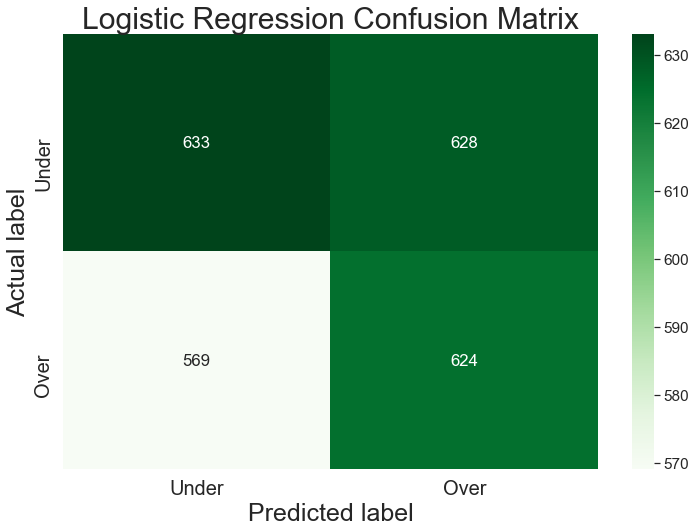

In [28]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, base_logred_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Logistic Regression Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

In [29]:
### Decision Tree

# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

dtc = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 6, min_samples_leaf = 6, min_samples_split = 6)
dtc.fit(X_train, y_train)

dtc_train_pred = dtc.predict(X_train)
dtc_test_pred = dtc.predict(X_test)

dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', dtc_f1_train)
print('Test F1 score: ', dtc_f1_test)



Train F1 score:  0.578
Test F1 score:  0.504


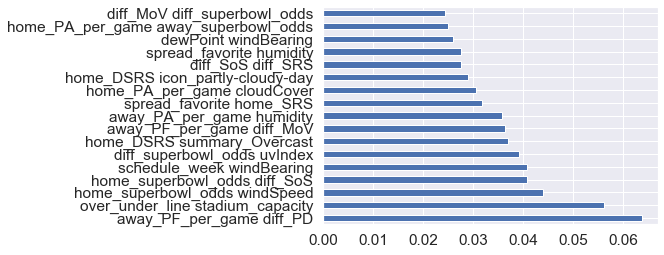

In [30]:
feat_importances = pd.Series(dtc.feature_importances_, index=df_poly2.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

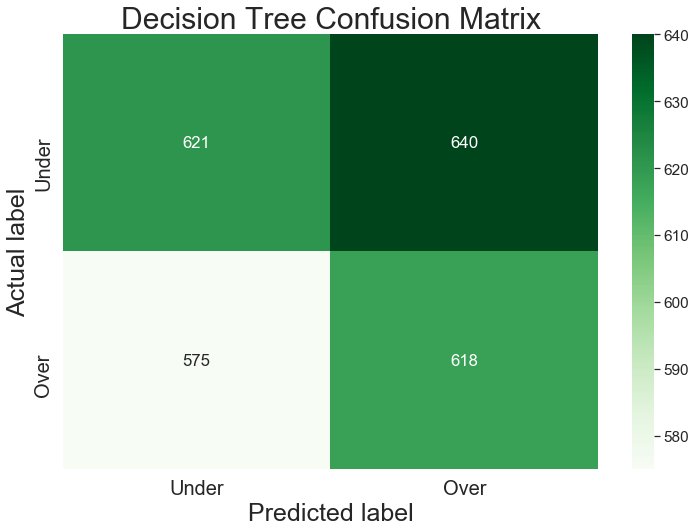

In [31]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, dtc_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Decision Tree Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')



In [32]:
### Random Forest

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Train F1 score:  0.641
Test F1 score:  0.468


Text(0.5, 44.5, 'Predicted label')

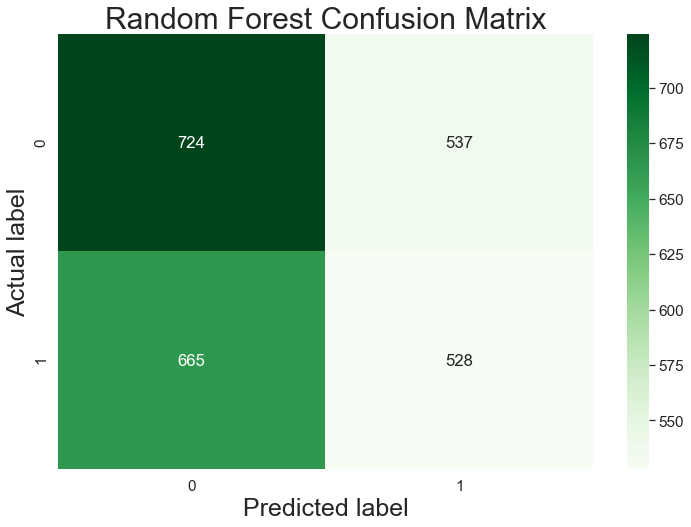

In [33]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, rfc_predicted, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Random Forest Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
#cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
#cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')


In [34]:
### SVM Model

#Import svm model
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)
svm_pred_train = svm.predict(X_train)

#Score
svm_f1_train = round(f1_score(y_train, svm_pred_train), 3)
svm_f1_test = round(f1_score(y_test, svm_pred), 3)

print('Train F1 score: ', svm_f1_train)
print('Test F1 score: ', svm_f1_test)

Train F1 score:  0.65
Test F1 score:  0.479


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

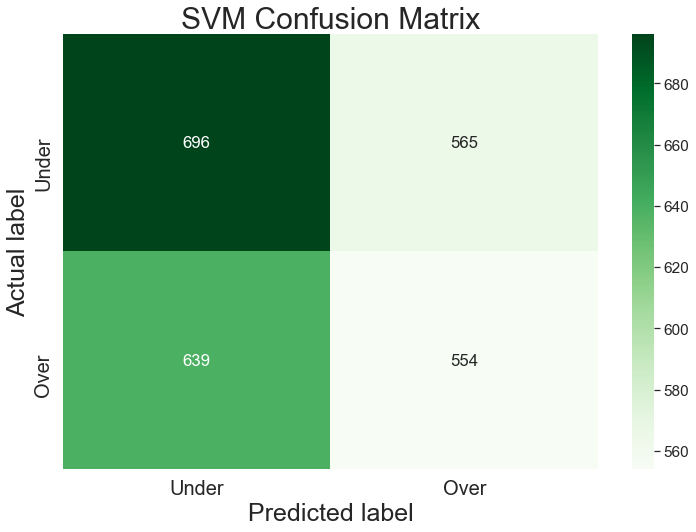

In [35]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, svm_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('SVM Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')



# KNN

In [ ]:
# Will take some time
acc = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    acc.append(metrics.f1_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Recall vs. K Value')
plt.xlabel('K')
plt.ylabel('Recall')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)

KNN_train_preds = knn.predict(X_train)
KNN_preds = knn.predict(X_test)

In [ ]:
KNN_recall = metrics.recall_score(y_test, KNN_preds)
KNN_train_f1_score = f1_score(y_train, KNN_train_preds)
KNN_f1_score = f1_score(y_test, KNN_preds)


print('Recall Score: ', KNN_recall)
print('Train F1 score: ', KNN_train_f1_score)
print('Test F1 score: ', KNN_f1_score)

In [ ]:
### Final Scores 

print('Baseline Logistic Regression:')
print('      Train F1 score: ', base_logred_train_f1_score)
print('      Test F1 score: ', base_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Train F1 score: ', dtc_f1_train)
print('      Test F1 score: ', dtc_f1_test)
print('')
print('Random Forest:')
print('      Train F1 score: ', rfc_f1_train)
print('      Test F1 score: ', rfc_f1_test)
print('')
print('Support Vector Machine:')
print('      Train F1 score: ', svm_f1_train)
print('      Test F1 score: ', svm_f1_test)